In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [3]:
# 构建人造数据集
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 人工噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000) 

In [4]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.8966,  0.7019]) 
label: tensor([-1.9828])


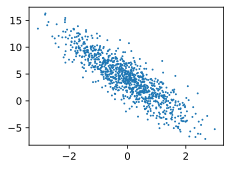

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成一个从0到数据长度的序列，用作索引
    random.shuffle(indices)  # 打乱索引
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]) # 防止溢出
        yield features[batch_indices], labels[batch_indices]


batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1070, -0.5877],
        [-0.0308, -0.0326],
        [ 0.3196,  1.2160],
        [ 0.2164, -0.5535],
        [-0.9674,  0.6484],
        [ 0.0534,  0.6255],
        [-0.1280,  0.5771],
        [ 0.0677, -1.3894],
        [-0.2972, -0.7417],
        [ 0.2549, -1.3923]]) 
 tensor([[5.9782],
        [4.2592],
        [0.6923],
        [6.5360],
        [0.0837],
        [2.1684],
        [1.9693],
        [9.0602],
        [6.1448],
        [9.4502]])


In [7]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [9]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

In [10]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            


In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.030313
epoch 2, loss 0.000117
epoch 3, loss 0.000051


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b }')

w的估计误差: tensor([0.0006, 0.0008], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)


---
线性回归简洁实现

In [14]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [16]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10 
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.5290, -2.1486],
         [ 0.5130, -0.6723],
         [ 1.4408, -0.9079],
         [ 0.9977,  0.1468],
         [ 1.0329,  1.1527],
         [-1.2881,  1.1353],
         [ 0.2271,  1.3464],
         [ 0.3961,  0.0629],
         [ 1.2568, -1.5304],
         [ 0.6243, -0.3541]]),
 tensor([[12.5713],
         [ 7.5074],
         [10.1716],
         [ 5.6837],
         [ 2.3591],
         [-2.2303],
         [ 0.0593],
         [ 4.7808],
         [11.9147],
         [ 6.6579]])]

In [18]:
from torch import nn
# nn 即 神经网络， 里面定义了很多的层
net = nn.Sequential(nn.Linear(2, 1)) # Sequential可以看作一个层的列表（容器），这行代码表示这个容器里有一个Linear层

In [20]:
net[0].weight.data.normal_(0, 0.01)  # 层容器里的第一个，即线性层，给权重赋值
net[0].bias.data.fill_(0) # 给偏差赋值

tensor([0.])

In [22]:
loss = nn.MSELoss()  # 定义好的均方误差（也称为平方L2范数）

In [24]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)  # 定义好的优化器

In [49]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000096
epoch 2, loss 0.000096
epoch 3, loss 0.000095
